# Setup initial code environment

1) Make sure we can reload python files when we make changes.
2) Load the base-notebook which will download all the python utility files and check versions of TensorFlow and Python.
3) Setup imports we will need for this notebook

In [2]:
%run ../../base-notebook.ipynb

2023-06-04 21:52:13 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/contents.txt [666/666] -> "../../ext/contents.txt" [1]
2023-06-04 21:52:13 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_callback.py [8151/8151] -> "../../ext/ml_callback.py" [1]
2023-06-04 21:52:13 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_internal.py [2478/2478] -> "../../ext/ml_internal.py" [1]
2023-06-04 21:52:13 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_io.py [1572/1572] -> "../../ext/ml_io.py" [1]
2023-06-04 21:52:13 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_layer.py [7416/7416] -> "../../ext/ml_layer.py" [1]
2023-06-04 21:52:13 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_plot.py [12765/12765] -> "../../ext/ml_plot.py" [1]
2023-06-04 21:52:13 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_util.py [2061/2061] -> "../../ext/ml_util.py" [1]
2023-06-0

In [2]:
import sys
import os

sys.path.append("../../ext")

import ext.ml_callback as mlc
import ext.ml_io as mli
import ext.ml_layer as mll
import ext.ml_plot as mlp
import ext.ml_util as mlu
import ext.ml_data as mld
import ext.ml_view as mlv
import ext.ml_internal as mlint

import tensorflow as tf

import opendatasets as od

from keras import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dense, Activation, RandomFlip, RandomZoom, RandomHeight, \
    RandomWidth, RandomRotation, Input, GlobalAveragePooling2D, Rescaling, Conv2D, \
    MaxPool2D, Dropout, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.utils import image_dataset_from_directory

# Configure mixed-precision so we can improve the performance

In [3]:
# BASE_MODEL_NAME is used as a folder name for saved models.
IMG_SHAPE = (224, 224)

In [4]:
mlu.set_mixed_precision_policy_for_gpu()

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  METAL, no compute capability (probably not an Nvidia GPU)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


# Download the dataset from Kaggle (kaggle.json API key neccesary)

In [7]:
# Download the dogs and cats dataset
od.download_kaggle_dataset(dataset_url="https://www.kaggle.com/datasets/chetankv/dogs-cats-images/download?datasetVersionNumber=1",
                           data_dir="./data")

100%|██████████| 435M/435M [00:13<00:00, 34.7MB/s] 


# Inspect the contents of the downloaded dataset

In [5]:
train_dir = "./data/dogs-cats-images/dataset/training_set"
test_dir = "./data/dogs-cats-images/dataset/test_set"

In [6]:
mli.list_dir_summary(train_dir)

There are 2 directories, and 1 in ./data/dogs-cats-images/dataset/training_set
There are 0 directories, and 4000 in ./data/dogs-cats-images/dataset/training_set/dogs
There are 0 directories, and 4000 in ./data/dogs-cats-images/dataset/training_set/cats


In [7]:
mli.list_dir_summary(test_dir)

There are 2 directories, and 0 in ./data/dogs-cats-images/dataset/test_set
There are 0 directories, and 1000 in ./data/dogs-cats-images/dataset/test_set/dogs
There are 0 directories, and 1000 in ./data/dogs-cats-images/dataset/test_set/cats


# Show some random images from disk of the downloaded dataset

In [ ]:
mlv.show_random_image_from_disk(target_dir=train_dir, target_class="dogs")

In [ ]:
mlv.show_random_image_from_disk(target_dir=train_dir, target_class="cats")

# Create datasets for the train and test images

In [6]:
train_images = image_dataset_from_directory(directory=train_dir,
                             label_mode="categorical",
                             batch_size=32,
                             image_size=IMG_SHAPE,
                             shuffle=True)

test_images = image_dataset_from_directory(directory=test_dir,
                             label_mode="categorical",
                             batch_size=32,
                             image_size=IMG_SHAPE,
                             shuffle=True)

len(train_images), len(test_images)

Found 8000 files belonging to 2 classes.
Metal device set to: Apple M1 Max
Found 2000 files belonging to 2 classes.


(250, 63)

# Get class-names from the dataset

In [7]:
class_names = mld.get_class_names_from_dataset(train_images)
class_names

['cats', 'dogs']

# Inspect some random images from the dataset to check image size, and quality

In [ ]:
mlv.show_images_from_dataset(dataset=train_images, shape=(4, 8))

# Create data augmentation layers for training

In [8]:
data_augementation_layer = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(.2),
    RandomHeight(.2),
    RandomWidth(.2),
    RandomZoom(.2),
    Rescaling(1/255.),
], name="data_augmentation")

# Create the model

In [9]:
def conv_layer(x, filters, kernel_size=(2, 2), padding="valid"):
    x = Conv2D(filters=filters, kernel_size=kernel_size, activation="relu", padding=padding)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    return Dropout(rate=.25)(x)

input_layer = Input(shape=IMG_SHAPE + (3,), name="input_layer")
x = data_augementation_layer(input_layer)
x = conv_layer(x=x, filters=16, kernel_size=(3, 3))
x = conv_layer(x=x, filters=32, kernel_size=(3, 3))
x = conv_layer(x=x, filters=64, kernel_size=(3, 3))
x = GlobalAveragePooling2D()(x)
x = Dense(units=16, activation="relu")(x)
x = Dense(units=len(class_names), name="output_dense_layer")(x)
output_layer = Activation(activation="softmax", dtype=tf.float32, name="output_activation_layer")(x)

model = Model(input_layer, output_layer)

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.002),
              metrics=["accuracy"])

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, None, None, 16)    448       
                                                                 
 batch_normalization (BatchN  (None, None, None, 16)   64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 16)   0         
 )                                                               
                                                             

In [10]:
mll.list_model(model=model, recursive=False)

row   | name (type)                                       | dtype   | policy        | trainable | output shape
0     | input_layer              (InputLayer            ) | float32 | float32       | True      | [(None, 224, 224, 3)] 
1     | data_augmentation        (Sequential            ) | float32 | mixed_float16 | True      | (None, None, None, 3) 
2     | conv2d                   (Conv2D                ) | float32 | mixed_float16 | True      | (None, None, None, 16)
3     | batch_normalization      (BatchNormalization    ) | float32 | mixed_float16 | True      | (None, None, None, 16)
4     | max_pooling2d            (MaxPooling2D          ) | float32 | mixed_float16 | True      | (None, None, None, 16)
5     | dropout                  (Dropout               ) | float32 | mixed_float16 | True      | (None, None, None, 16)
6     | conv2d_1                 (Conv2D                ) | float32 | mixed_float16 | True      | (None, None, None, 32)
7     | batch_normalization_1    (BatchNor

We can see that the only layer which is not trainable is the efficientnetv2-b0 model layer and all the other layers are trainable, so this setup is correct for feature extraction. In a later setup we can enable a number of layers within the efficientnetv2-b0 to increase accuracy.

# Create the neccesary callbacks to evaluate

In [11]:
tensorflow_callback = mlc.create_tensorboard_callback('cats-dogs-model-categorical-tiny-dropout')
model_checkpoint_callback = mlc.create_model_checkpoint_callback('cats-dogs-model-categorical-tiny-dropout', save_weights_only=True, save_best_only=True)
early_stopping_callback = mlc.create_early_stopping_callback()
reduce_lr_on_plateau_callback = mlc.create_reduce_lr_on_plateau_callback()

callbacks = [tensorflow_callback, model_checkpoint_callback, early_stopping_callback, reduce_lr_on_plateau_callback]

Saving TensorBoard log files to: ./logs/cats-dogs-model-categorical-dropout/20230612-110353


# Fit the mode

In [12]:
model_history = model.fit(
    epochs=50,
    x=train_images,
    steps_per_epoch=len(train_images),
    validation_data=test_images,
    validation_steps=int(0.15 * len(test_images)),
    callbacks=callbacks,
)

Epoch 1/50


2023-06-12 11:03:54.159638: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


250/250 [==============================] - ETA: 0s - loss: 0.6734 - accuracy: 0.5828
Epoch 1: val_loss improved from inf to 0.69334, saving model to ./checkpoints/cats-dogs-model-categorical-dropout/model-epoch-01-val_loss-0.69.hdf5
250/250 [==============================] - 64s 251ms/step - loss: 0.6734 - accuracy: 0.5828 - val_loss: 0.6933 - val_accuracy: 0.5556 - lr: 0.0020
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 0.6560 - accuracy: 0.6059
Epoch 2: val_loss improved from 0.69334 to 0.66702, saving model to ./checkpoints/cats-dogs-model-categorical-dropout/model-epoch-02-val_loss-0.67.hdf5
250/250 [==============================] - 63s 250ms/step - loss: 0.6560 - accuracy: 0.6059 - val_loss: 0.6670 - val_accuracy: 0.5868 - lr: 0.0020
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 0.6437 - accuracy: 0.6212
Epoch 3: val_loss did not improve from 0.66702
250/250 [==============================] - 63s 251ms/step - loss: 0.6437 - accurac

# Inspect the history of fitting the model

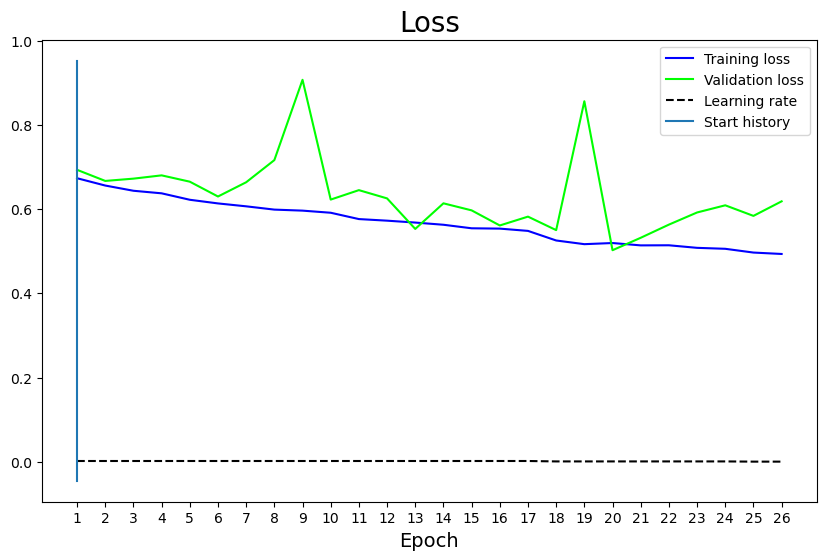

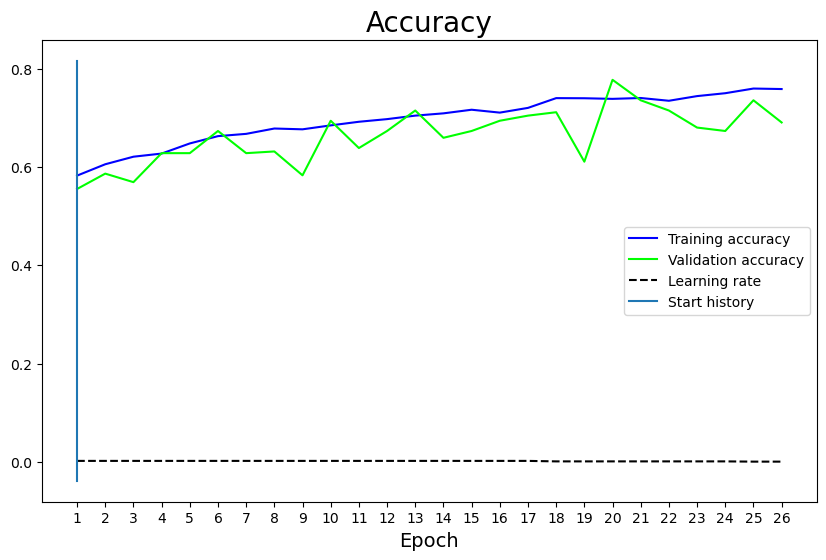

In [13]:
mlp.plot_history(model_history)

# Evaluate the model

In [14]:
model_evaluation = model.evaluate(x=test_images)
model_evaluation

63/63 [==============================] - 4s 64ms/step - loss: 0.5276 - accuracy: 0.7375


[0.5276387333869934, 0.737500011920929]

# Create confusion matrix on all the predictions of the test images

In [15]:
y_true, y_pred = mll.predict_classification_dataset_with_labels(model, test_images)

1/1 [==============================] - 0s 83ms/step


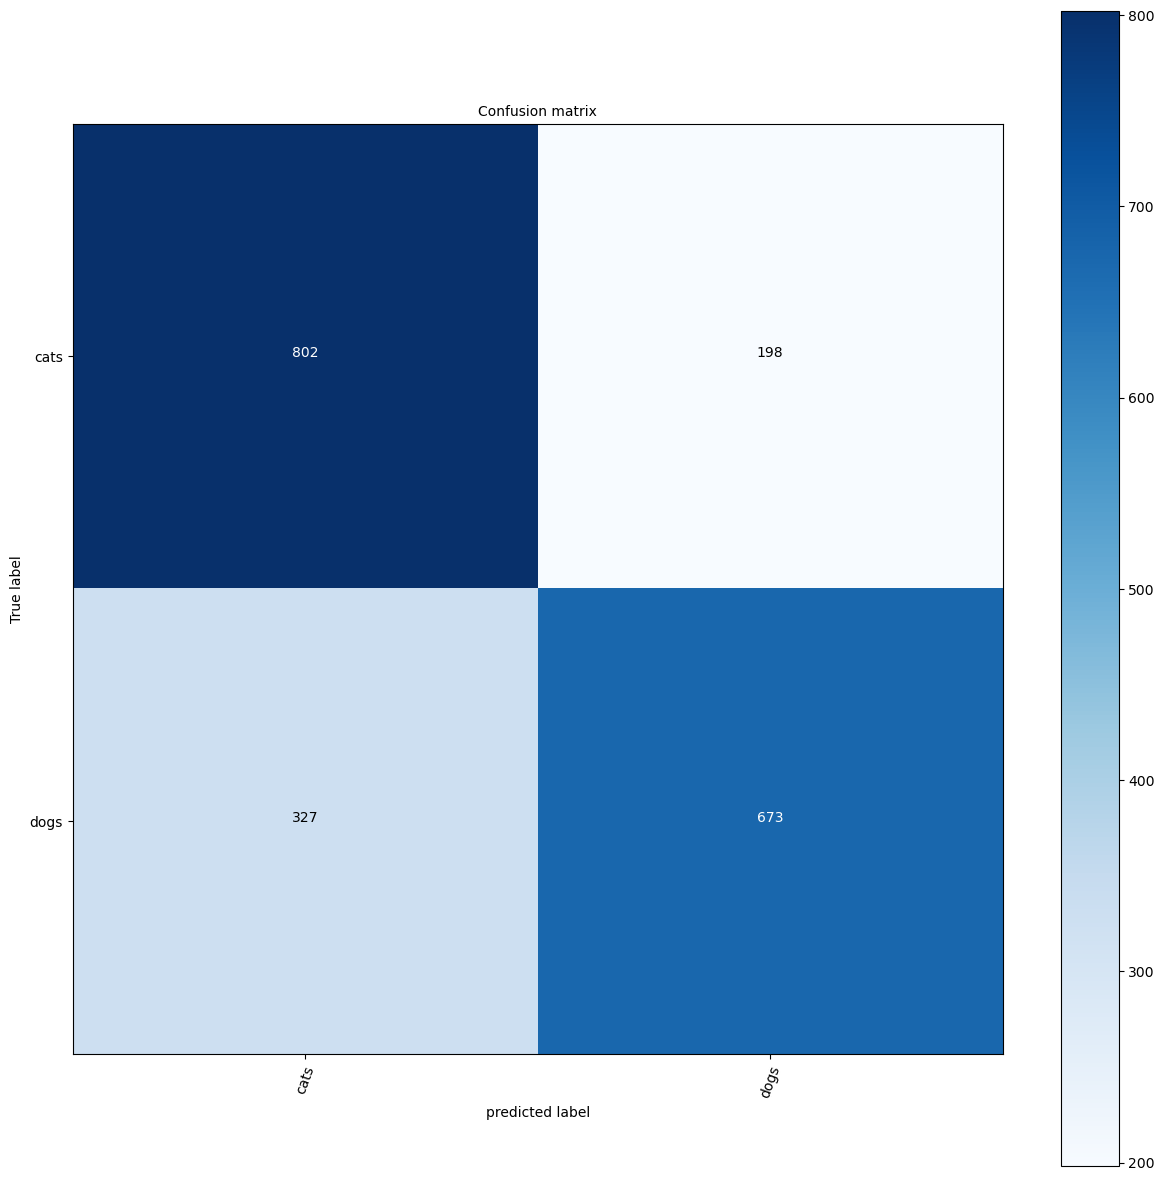

In [16]:
mlp.plot_classification_confusion_matrix(y_true=y_true, y_pred=y_pred, class_names=class_names)

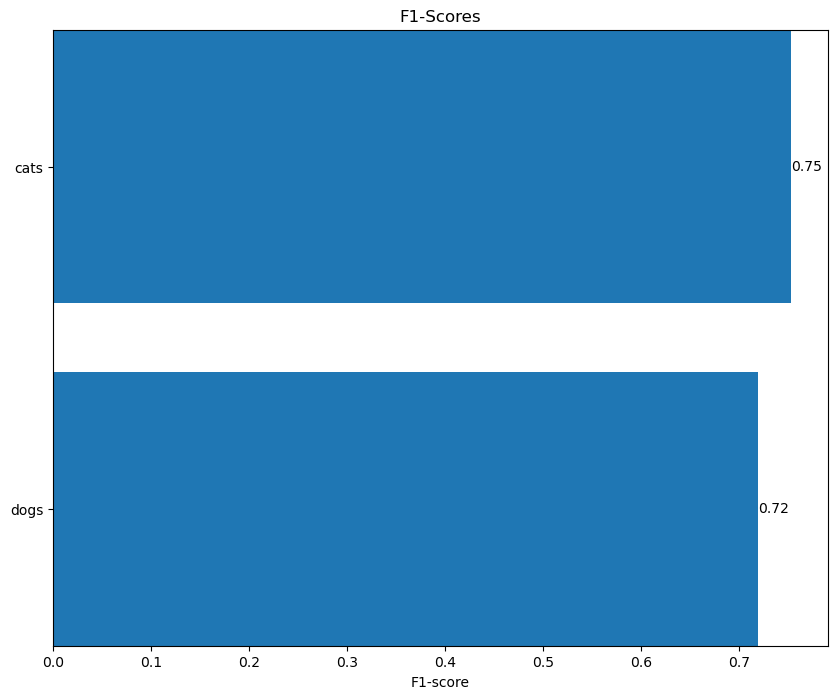

In [17]:
mlp.plot_classification_report_f1_score(y_true=y_true, y_pred=y_pred, class_names=class_names)

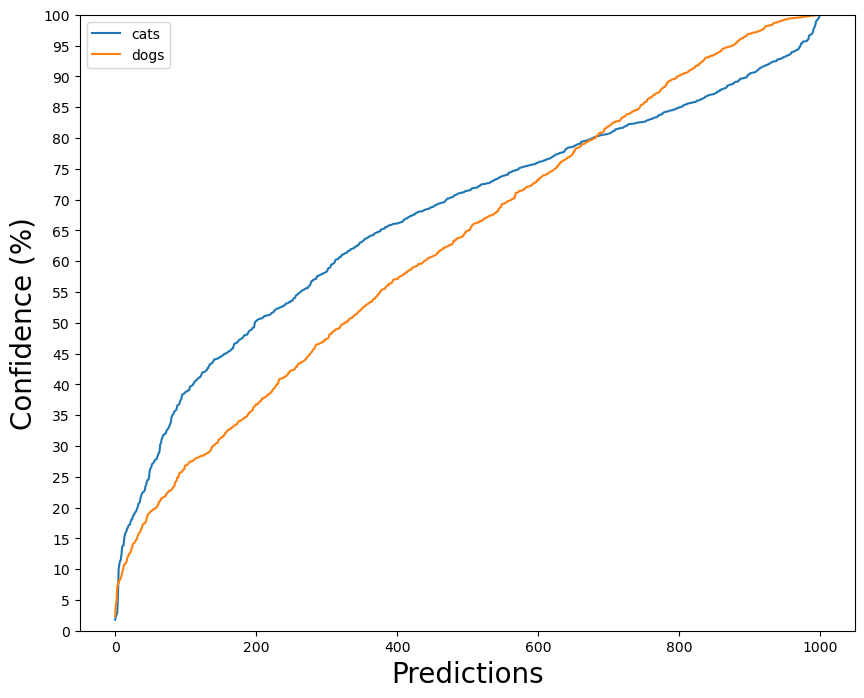

In [18]:
mlp.plot_classification_prediction_confidence(y_true=y_true, y_pred=y_pred, class_names=class_names)

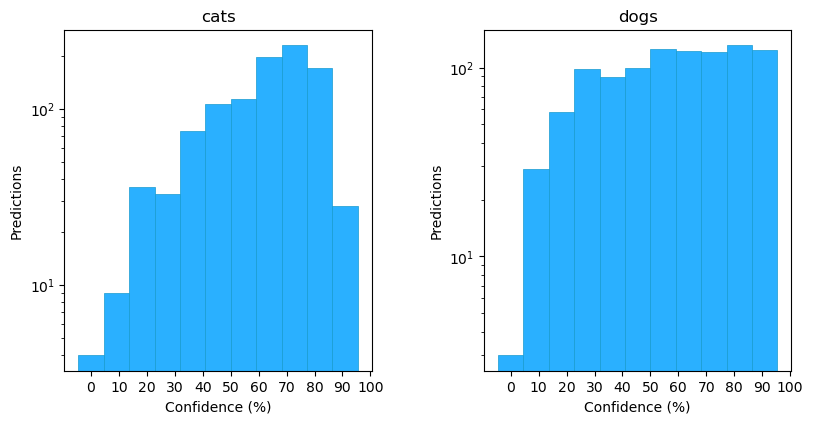

In [19]:
mlp.plot_classification_prediction_confidence_histogram(y_true=y_true, y_pred=y_pred, class_names=class_names)


# Make some predictions of our own

In [22]:
SAMPLES_DIR = "./samples"

mli.list_dir_summary(SAMPLES_DIR)

There are 0 directories, and 6 in ./samples


In [ ]:
cat = mli.load_image_as_tensor(filename=os.path.join(SAMPLES_DIR, "cat_1.jpeg"), img_shape=IMG_SHAPE, scale=False)
y = mlint.sparse_labels(model.predict(x=mld.add_batch_to_tensor(cat)))
mlv.show_single_image_from_nparray_or_tensor(image=cat, title=f"Pred: {class_names[y[0]]}")

In [ ]:
cat = mli.load_image_as_tensor(filename=os.path.join(SAMPLES_DIR, "cat_2.jpeg"), img_shape=IMG_SHAPE, scale=False)
y = mlint.sparse_labels(model.predict(x=mld.add_batch_to_tensor(cat)))
mlv.show_single_image_from_nparray_or_tensor(image=cat, title=f"Pred: {class_names[y[0]]}")

In [ ]:
cat = mli.load_image_as_tensor(filename=os.path.join(SAMPLES_DIR, "cat_3.jpg"), img_shape=IMG_SHAPE, scale=False)
y = mlint.sparse_labels(model.predict(x=mld.add_batch_to_tensor(cat)))
mlv.show_single_image_from_nparray_or_tensor(image=cat, title=f"Pred: {class_names[y[0]]}")

In [ ]:
dog = mli.load_image_as_tensor(filename=os.path.join(SAMPLES_DIR, "dog_1.jpg"), img_shape=IMG_SHAPE, scale=False)
y = mlint.sparse_labels(model.predict(x=mld.add_batch_to_tensor(dog)))
mlv.show_single_image_from_nparray_or_tensor(image=dog, title=f"Pred: {class_names[y[0]]}")

In [ ]:
dog = mli.load_image_as_tensor(filename=os.path.join(SAMPLES_DIR, "dog_2.jpg"), img_shape=IMG_SHAPE, scale=False)
y = mlint.sparse_labels(model.predict(x=mld.add_batch_to_tensor(dog)))
mlv.show_single_image_from_nparray_or_tensor(image=dog, title=f"Pred: {class_names[y[0]]}")

In [ ]:
dog = mli.load_image_as_tensor(filename=os.path.join(SAMPLES_DIR, "dog_3.jpg"), img_shape=IMG_SHAPE, scale=False)
y = mlint.sparse_labels(model.predict(x=mld.add_batch_to_tensor(dog)))
mlv.show_single_image_from_nparray_or_tensor(image=dog, title=f"Pred: {class_names[y[0]]}")

# Save the model so we can perform a training

In [20]:
mll.save_model_alt(model=model, directory=f"./models", name="cats_dogs_categorical-tiny-dropout", format="h5")

In [25]:
# In case we need to load the model again
model = mll.load_model_alt(directory=f"./models", name="cats_dogs_categorical-tiny-dropout", format="h5")

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b3 (Function  (None, None, None, 1536)  12930622 
 al)                                                             
                                                                 
 global_average_pooling_2d (  (None, 1536)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_dense_layer (Dense)  (None, 2)                 3074      
                                                             